## Live Stream

In [15]:
import cv2
import threading
from queue import Queue, Empty

# bufferless VideoCapture
class VideoCapture:

    def __init__(self, name, IP):
        print(f"Initializing VideoCapture with name: {name} and IP: {IP}")
        self.cap = cv2.VideoCapture(name)
        self.cap.open(IP)  # comment this line if you don't need to operate using mobile camera
        self.q = Queue()
        self.running = True
        self.thread = threading.Thread(target=self._reader)
        self.thread.daemon = True
        self.thread.start()
        print("VideoCapture initialized and reader thread started")

    # read frames as soon as they are available, keeping only most recent one
    def _reader(self):
        while self.running:
            ret, frame = self.cap.read()
            if not ret:
                break
            if not self.q.empty():
                try:
                    self.q.get_nowait()  # discard previous (unprocessed) frame
                except Queue.Empty:
                    pass
            self.q.put(frame)

    def read(self):
        try:
            frame = self.q.get(timeout=1)  # Wait for a frame with timeout
            return True, frame  # Always return (ret, frame)
        except Empty:
            return False, None  # Return (False, None) if no frame is available  

    def release(self):
        self.running = False
        self.thread.join()  # Ensure the thread has finished
        self.cap.release()

    def isOpened(self):
        return self.cap.isOpened()

In [31]:
cap = VideoCapture(0, "https://172.20.10.2:8080/video")
fps = 30
print(f"Frames per second: {int(fps)}")

Initializing VideoCapture with name: 0 and IP: https://172.20.10.2:8080/video
VideoCapture initialized and reader thread started
Frames per second: 30


## Ball Tracking
Outcome: y_positions

In [32]:
RADIUS_CM = 2

True
Frames processed: 50
Motion Frequency: 1.20 Hz
Average Compression Depth: 5.95 cm


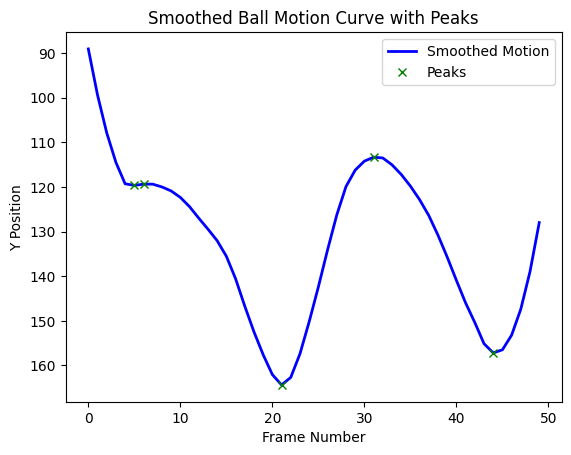

Frames processed: 100
Motion Frequency: 1.48 Hz
Average Compression Depth: 6.50 cm


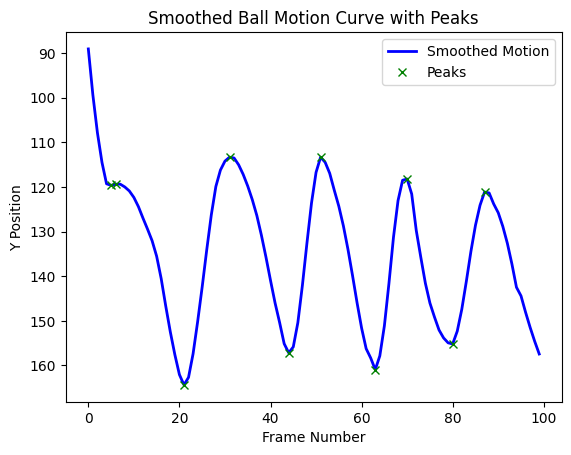

Frames processed: 150
Motion Frequency: 1.59 Hz
Average Compression Depth: 6.28 cm


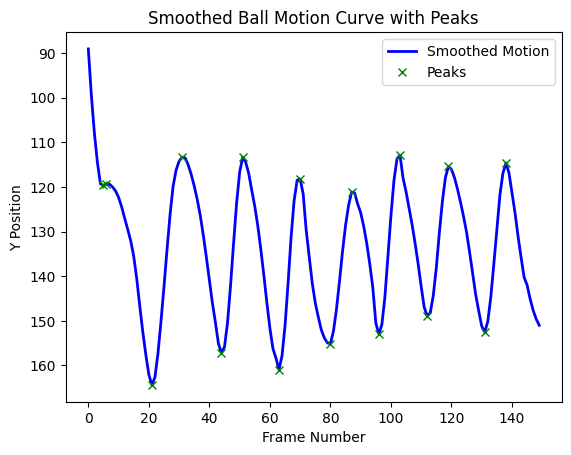

Frames processed: 200
Motion Frequency: 1.67 Hz
Average Compression Depth: 6.13 cm


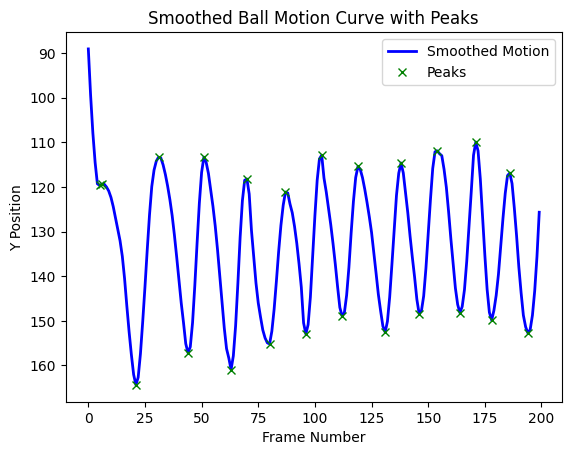

Frames processed: 250
Motion Frequency: 1.79 Hz
Average Compression Depth: 5.30 cm


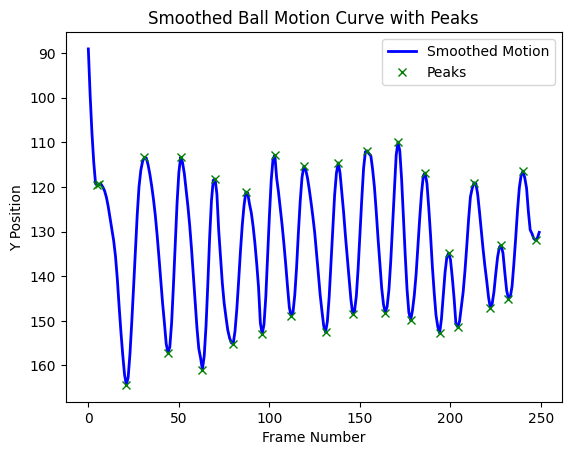

Frames processed: 300
Motion Frequency: 1.81 Hz
Average Compression Depth: 5.11 cm


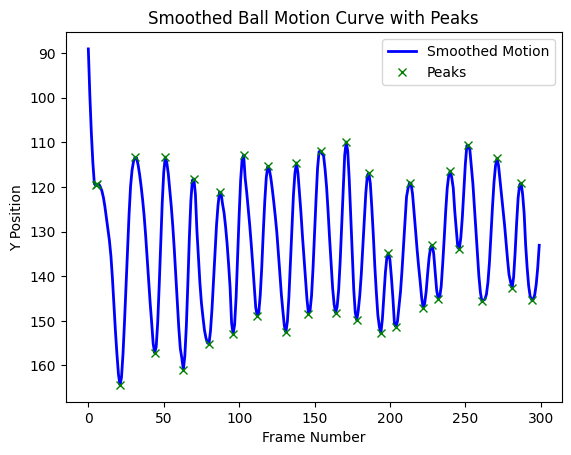

Frames processed: 350
Motion Frequency: 1.80 Hz
Average Compression Depth: 5.09 cm


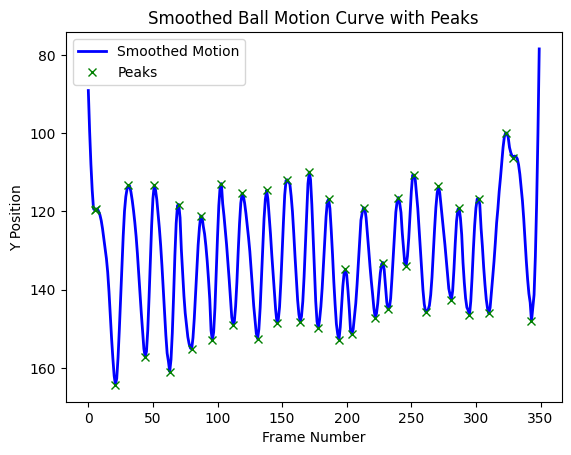

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks

# Initialize variables
lower_orange = np.array([5, 120, 120])  
upper_orange = np.array([25, 255, 255])  
y_positions = []  

sum_r = 0
avg_r = 0

curr_frame_count = 0

print(cap.isOpened())

while cap.isOpened():
    ret, frame = cap.read()
    frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    if not ret:
        break

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower_orange, upper_orange)
    gray = cv2.GaussianBlur(cv2.bitwise_and(frame, frame, mask=mask), (9, 9), 2)
    gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)

    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1.2, 30, param1=50, param2=30, minRadius=5, maxRadius=50)

    if circles is not None:
        x, y, r = min(circles[0], key=lambda c: c[2])  
        y_positions.append(y)  
        sum_r += r

        # Draw detected ball
        cv2.circle(frame, (int(x), int(y)), int(r), (0, 255, 0), 2)
        cv2.circle(frame, (int(x), int(y)), 2, (0, 0, 255), 3)

    cv2.imshow("Ball Tracking", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    # Every 10 frames execute the code below
    if len(y_positions) % 50 == 0 and len(y_positions) > 0 and curr_frame_count < len(y_positions):
        curr_frame_count = len(y_positions)

        print(f"Frames processed: {len(y_positions)}")
        
        avg_r = sum_r / len(y_positions)

        pixel_to_cm = RADIUS_CM / avg_r

        smoothed_y = savgol_filter(y_positions, window_length=10, polyorder=2)

        # Find peaks (local maxima) in the smoothed signal
        peaks_max = find_peaks(-smoothed_y, distance=10)  # Negative because higher y is downward
        peaks_min = find_peaks(smoothed_y, distance=10) 
        peaks = np.sort(np.concatenate((peaks_max[0], peaks_min[0])))

        # Calculate motion frequency (rate)
        if len(peaks_max[0]) > 1:
            # peak_to_peak_frames contains the difference in frame numbers between 2 conesecutive peaks
            peak_to_peak_frames = np.diff(peaks_max[0])  # Time between peaks in frames
            avg_peak_to_peak_frames = np.mean(peak_to_peak_frames)  # Average period in frames
            avg_period_seconds = avg_peak_to_peak_frames / fps  # Convert to seconds
            frequency_hz = 1 / avg_period_seconds  # Convert period to frequency
        else:
            frequency_hz = None
            avg_peak_to_peak_frames = None

        # Calculate depth of motion (peak-to-peak distance)
        if len(peaks) > 1:
            compression_depth_px = np.diff(smoothed_y[peaks])  # Distance between peaks in pixels
            compression_depth_px = np.abs(compression_depth_px)
            avg_compression_depth_px= np.mean(compression_depth_px)  # Average depth in pixels
            avg_compression_depth_cm = avg_compression_depth_px * pixel_to_cm  # Convert to cm  

        # Print extracted values
        print(f"Motion Frequency: {frequency_hz:.2f} Hz" if frequency_hz else "Not enough peaks detected")
        print(f"Average Compression Depth: {avg_compression_depth_cm:.2f} cm" if avg_compression_depth_cm else "Not enough peaks detected")

        # Plot the peaks on the motion curve
        plt.plot(smoothed_y, label="Smoothed Motion", color="blue", linewidth=2)
        plt.plot(peaks, smoothed_y[peaks], "x", label="Peaks", color="green")
        plt.xlabel("Frame Number")
        plt.ylabel("Y Position")
        plt.title("Smoothed Ball Motion Curve with Peaks")
        plt.legend()
        plt.gca().invert_yaxis()
        plt.show()

cap.release()
cv2.destroyAllWindows()